<a href="https://colab.research.google.com/github/h1pp-o/Pipeline_Sales_Expanstion_Strategy/blob/main/03B_XGBoost_Best_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
This File Assumes:
  "7. Predictive Model Dataset.csv" - The File Produced From "02_Initial Cleaning.ipynb"
  This File Produces The Features Which We Will Be Used As Parameters For Our Optimization Analysis
  By Using XGBoost for Binary Classification.
'''

'\nThis File Assumes:\n  "7. Predictive Model Dataset.csv" - The File Produced From "02_Initial Cleaning.ipynb"\n  This File Produces The Features Which We Will Be Used As Parameters For Our Optimization Analysis\n  By Using XGBoost for Binary Classification.\n'

In [ ]:
#@title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Import Modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc, fbeta_score, make_scorer
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import (
    RandomOverSampler, SMOTE
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

# Halo Data

In [ ]:
#@title Global Path Variables
PATH = '/content/drive/Shareddrives/OPIM 5770/Files to Present To Torigen/Final Data Files'
MODEL = '7. Predictive Model Dataset.csv'

df = pd.read_csv(os.path.join(PATH,MODEL))

In [ ]:
#@title Global Dictionaries and Lists

columns_to_keep = [
                    'Company name',
                    'Zip Code',
                    'ConvertedCustomer',
                    'Total Population',
                    'Percent Age 5-14',
                    'Halo Population',
                    'Halo Income',
                    'Halo Clinic Count',
                    'Percentage of Graduate Degree'
                    ]

In [ ]:
#@title Derive new columns

df['Percentage of No High School Diploma'] = (df['Number No High School Diploma'] / df['Total Population']) * 100
df['Percentage of High School Graduate'] = (df['Number High School Graduate'] / df['Total Population']) * 100
df['Percentage of Bachelor Degree'] = (df['Number Bachelors Degree'] / df['Total Population']) * 100
df['Percentage of Graduate Degree'] = (df['Number Graduate Degree'] / df['Total Population']) * 100

In [ ]:
#@title ModelTable ETL

df = (df
              .rename(columns=lambda x: x.strip())
              .query('Distance_Miles >= 0 and not `Mean Income`.isnull() and `Company State` not in ["AK", "HI"]')
              .loc[:, columns_to_keep]
)

## Attempt to remove duplicate zip code

In [ ]:
# Convert 'Zip Code' to integer and left pad with zeros
df['Zip Code'] = df['Zip Code'].fillna(0).astype(int)  # Fill NaN values with 0 and convert to int

# Format the 'Zip Code' column to have leading zeros and be a string
df['Zip Code'] = df['Zip Code'].apply(lambda x: str(x).zfill(5))

In [ ]:
# Count the occurrences of each unique ZIP code
zip_code_counts = df['Zip Code'].value_counts()

# Get the number of unique ZIP codes
unique_zip_codes = len(zip_code_counts)

print("Number of unique ZIP codes:", unique_zip_codes)
print("ZIP code counts for each unique ZIP code:")
print(zip_code_counts)

Number of unique ZIP codes: 6029
ZIP code counts for each unique ZIP code:
34787    12
30040    11
30115    11
32765    10
78130    10
         ..
08360     1
02145     1
12414     1
12477     1
31763     1
Name: Zip Code, Length: 6029, dtype: int64


In [ ]:
# Drop the 'Company name' column
df = df.drop('Company name', axis=1)

In [ ]:
df.columns.tolist()

['Zip Code',
 'ConvertedCustomer',
 'Total Population',
 'Percent Age 5-14',
 'Halo Population',
 'Halo Income',
 'Halo Clinic Count',
 'Percentage of Graduate Degree']

In [ ]:
df.shape

(10002, 8)

In [ ]:
df.head()

,Zip Code,ConvertedCustomer,Total Population,Percent Age 5-14,Halo Population,Halo Income,Halo Clinic Count,Percentage of Graduate Degree
0,06443,0,17713.0,11.8,4547851.0,5.672711e+11,177.0,22.977474
1,94520,0,38383.0,11.9,8876813.0,1.337001e+12,244.0,4.944897
2,11379,0,37906.0,12.3,20178387.0,2.576828e+12,329.0,10.987706
3,11375,0,72851.0,10.0,20271099.0,2.586441e+12,326.0,23.511002
4,11419,0,47430.0,9.2,20108496.0,2.568176e+12,323.0,5.471221


Make sure if the 'ConvertedCustomer' has at least one "1" make the unique retained row have "1"

In [ ]:
# Sort the DataFrame by 'ConvertedCustomer' in descending order, so rows with 1 come first
df = df.sort_values(by='ConvertedCustomer', ascending=False)

In [ ]:
# Then drop duplicates based on 'Zip Code' and keep the first occurrence (which has 1 if available, otherwise 0)
df = df.drop_duplicates(subset='Zip Code', keep='first')

In [ ]:
# Reset the index of the DataFrame
df = df.reset_index(drop=True)

In [ ]:
df.shape

(6029, 8)

In [ ]:
df['ConvertedCustomer'].value_counts()

0    4896
1    1133
Name: ConvertedCustomer, dtype: int64

In [ ]:
# Drop the 'Company name' column
df = df.drop('Zip Code', axis=1)

In [ ]:
df.columns.tolist()

['ConvertedCustomer',
 'Total Population',
 'Percent Age 5-14',
 'Halo Population',
 'Halo Income',
 'Halo Clinic Count',
 'Percentage of Graduate Degree']

In [ ]:
#@title Pearson correlation coefficient
# correlation_coefficient = df['Percent Age 5-14'].corr(df['ConvertedCustomer'])

# print(f"Pearson Correlation Coefficient: {correlation_coefficient}")

Confusion Matrix (Training Data):
 [[3937    3]
 [1343 2597]]


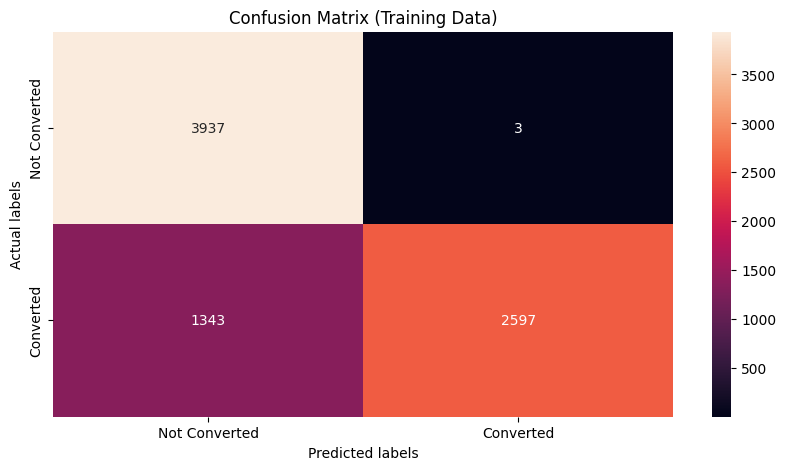

Classification Report (Training Data):
               precision    recall  f1-score   support

           0       0.75      1.00      0.85      3940
           1       1.00      0.66      0.79      3940

    accuracy                           0.83      7880
   macro avg       0.87      0.83      0.82      7880
weighted avg       0.87      0.83      0.82      7880


Confusion Matrix (Test Data):
 [[886  70]
 [219  31]]


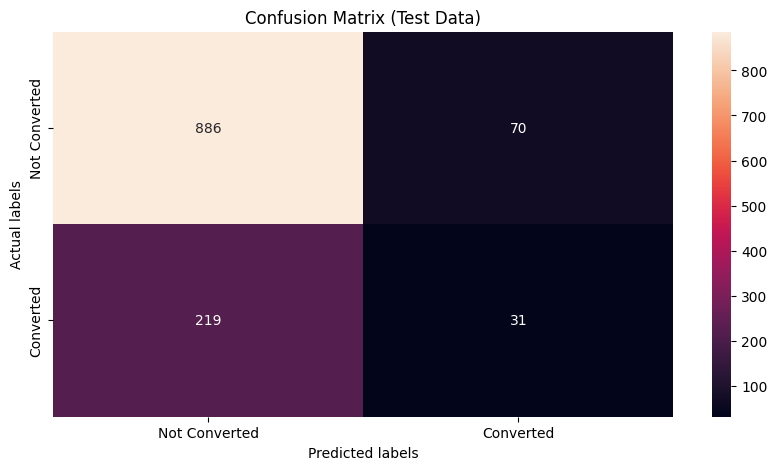

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.80      0.93      0.86       956
           1       0.31      0.12      0.18       250

    accuracy                           0.76      1206
   macro avg       0.55      0.53      0.52      1206
weighted avg       0.70      0.76      0.72      1206



<bound method Figure.tight_layout of <Figure size 1500x500 with 2 Axes>>

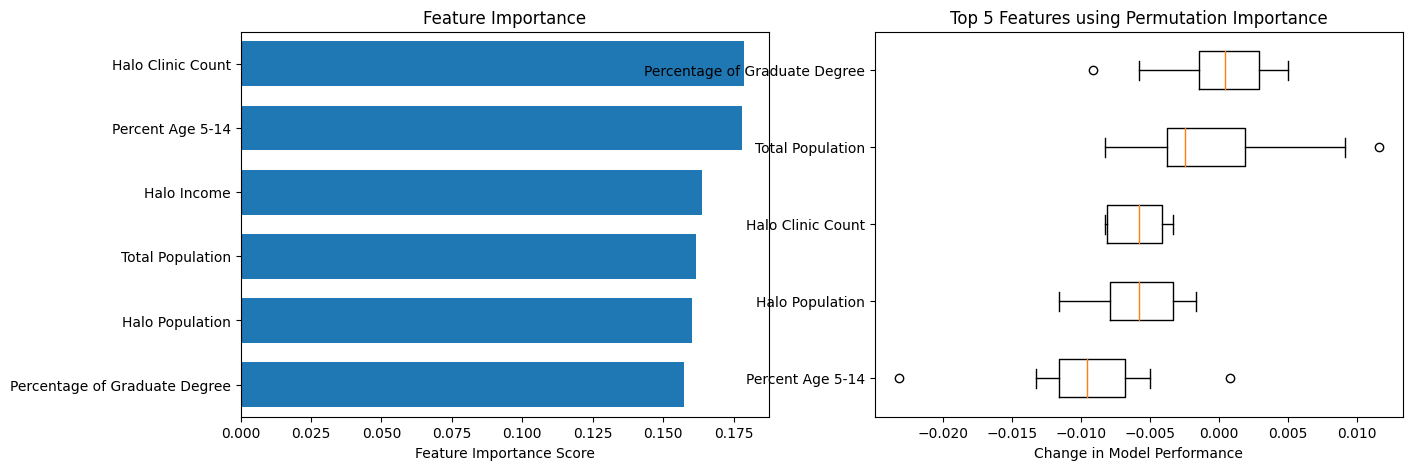

In [ ]:
#@title Modeling

# Constants
THRESHOLD = 0.5

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['Not Converted', 'Converted'])
    ax.yaxis.set_ticklabels(['Not Converted', 'Converted'])
    plt.show()

# Load and preprocess data
X = df.drop('ConvertedCustomer', axis=1)
y = df['ConvertedCustomer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class imbalance ratio
class_imbalance_ratio = len(y_train[y_train == 1]) / len(y_train[y_train == 0])

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Export
# import joblib
# joblib.dump(scaler, os.path.join(PATH, 'scaler.gz'))

# Oversample the minority class using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define parameter grid for XGBoost (find parameters that maximize "recall"
param_grid = {
    'max_depth': [7, 10],
    'learning_rate': [0.3],
    'gamma': [0.5],
    'subsample': [0.8],
    'colsample_bytree': [0.6, 0.8],
    'min_child_weight': [1]
}

# Create an XGBoost classifier
best_xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    nthread=4,
    colsample_bytree=0.6,
    gamma=0.5,
    learning_rate=0.3,
    max_depth=10,
    min_child_weight=1,
    subsample=0.8,
    scale_pos_weight=class_imbalance_ratio
)

# Fit the classifier to resampled training data
best_xgb_classifier.fit(X_resampled, y_resampled)

# Make predictions on training data
y_pred_train_prob = best_xgb_classifier.predict_proba(X_resampled)[:, 1]
y_pred_train = (y_pred_train_prob > THRESHOLD).astype(int)

# Calculate and plot confusion matrix for training data
conf_matrix_train = confusion_matrix(y_true=y_resampled, y_pred=y_pred_train)
print("Confusion Matrix (Training Data):\n", conf_matrix_train)
plot_confusion_matrix(conf_matrix_train, "Confusion Matrix (Training Data)")

# Print classification report for training data
print("Classification Report (Training Data):\n", classification_report(y_resampled, y_pred_train))

# Make predictions on test data
y_pred_test_prob = best_xgb_classifier.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_pred_test_prob > THRESHOLD).astype(int)

# Calculate and plot confusion matrix for test data
conf_matrix_test = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
print("\nConfusion Matrix (Test Data):\n", conf_matrix_test)
plot_confusion_matrix(conf_matrix_test, "Confusion Matrix (Test Data)")

# Print classification report for test data
print("Classification Report (Test Data):\n", classification_report(y_test, y_pred_test))

# Calculate permutation importance for the classifier on test data
result = permutation_importance(best_xgb_classifier, X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[::-1][:5]

# Sort the features based on tree-based feature importance
tree_importance_sorted_idx = np.argsort(best_xgb_classifier.feature_importances_)
tree_indices = np.arange(0, len(best_xgb_classifier.feature_importances_)) + 0.5

# Create subplots to visualize feature importance and permutation importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Visualize tree-based feature importance
ax1.barh(tree_indices, best_xgb_classifier.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(best_xgb_classifier.feature_importances_)))
ax1.set_xlabel("Feature Importance Score")
ax1.set_title("Feature Importance")

# Visualize permutation importance
ax2.boxplot(
    result.importances[perm_sorted_idx].T[:, ::-1][:, :5],
    vert=False,
    labels=X_train.columns[perm_sorted_idx][::-1][:5],
)
ax2.set_xlabel("Change in Model Performance")
ax2.set_title("Top 5 Features using Permutation Importance")

# Display the subplots
fig.tight_layout

In [ ]:
# pip install pdpbox


In [ ]:
# sklearn.ensemble._forest

# from sklearn.ensemble._partial_dependence import plot_partial_dependence
# from sklearn.ensemble._partial_dependence import partial_dependence

In [ ]:
def plot_partial_dependence(model, X, feature_name, plot_title):
    pdp_goals = pdp.pdp_isolate(model=model, dataset=X, model_features=X.columns, feature=feature_name)
    pdp.pdp_plot(pdp_goals, feature_name, plot_title)
    plt.show()


In [ ]:
#@title Feature Importance

# Create a dataframe with feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb_classifier.feature_importances_
})

# Sort the dataframe based on the importances
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("SUM(Importance) =", feature_importance_df['Importance'].sum())
feature_importance_df

SUM(Importance) = 1.0


,Feature,Importance
1,Percent Age 5-14,0.203382
2,Halo Population,0.173093
3,Halo Income,0.166883
4,Halo Clinic Count,0.160705
0,Total Population,0.149319
5,Percentage of Graduate Degree,0.146618
